# Combining Grounding DINO with Segment Anything (SAM) for text-based mask generation

In this notebook, we're going to combine 2 very cool models - [Grounding DINO](https://huggingface.co/docs/transformers/main/en/model_doc/grounding-dino) and [SAM](https://huggingface.co/docs/transformers/en/model_doc/sam). We'll use Grounding DINO to generate bounding boxes based on text prompts, after which we can prompt SAM to generate corresponding segmentation masks for them.

This is based on the popular [Grounded Segment Anything](https://github.com/IDEA-Research/Grounded-Segment-Anything) project - just with fewer lines of code as the models are now available in the Transformers library. Refer to the [paper](https://arxiv.org/abs/2401.14159) for details.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/grounded_sam.png"
alt="drawing" width="900"/>

<small> Grounded SAM overview. Taken from the <a href="https://github.com/IDEA-Research/Grounded-Segment-Anything">original repository</a>. </small>

Author of this notebook: [Eduardo Pacheco](https://huggingface.co/EduardoPacheco) - give him a follow on Hugging
 Face!

## Set-up environment

Let's start by installing 🤗 Transformers from source since Grounding DINO is brand new at the time of writing.

## Imports

Let's start by importing the required libraries.

## Result Utils

We'll store the detection results of Grounding DINO in a dedicated Python dataclass.

## Plot Utils

Below, some utility functions are defined as we'll draw the detection results of Grounding DINO on top of the image.

## Utils

## Grounded Segment Anything (SAM)

Now it's time to define the Grounded SAM approach!

The approach is very simple:
1. use Grounding DINO to detect a given set of texts in the image. The output is a set of bounding boxes.
2. prompt Segment Anything (SAM) with the bounding boxes, for which the model will output segmentation masks.

### Inference

Let's showcase Grounded SAM on our favorite image: the cats image from the COCO dataset.

Let's visualize the results:

In [ ]:
# plot_detections(image_array, detections, "cute_cats.png")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import requests
import torch
from PIL import Image
import json
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection, AutoTokenizer, AutoModel, AutoImageProcessor, AutoModelForDepthEstimation
import datasets

In [4]:
dataset = datasets.load_dataset("ntudlcv/dlcv_2024_final1", split = "val", streaming = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/761 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/45 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/45 [00:00<?, ?it/s]

In [5]:
model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda"
model_name="bert-large-uncased"
GD_processor = AutoProcessor.from_pretrained(model_id)
GD_model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
Bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
Bert_model = AutoModel.from_pretrained(model_name).to(device)
Dep_image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
Dep_model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf").to(0)

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

In [6]:
@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        l = []
        for i in range(len(detection_dict['labels'])):
            l.append(cls(score=detection_dict['scores'][i],
                   label=detection_dict['labels'][i],
                   box=BoundingBox(xmin=detection_dict['boxes'][i][0],
                                   ymin=detection_dict['boxes'][i][1],
                                   xmax=detection_dict['boxes'][i][2],
                                   ymax=detection_dict['boxes'][i][3])))
        return l

In [7]:
def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:
    # Convert PIL Image to OpenCV format
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # Iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        # Sample a random color for each detection
        xmin, ymin, xmax, ymax = int(box.xmin), int(box.ymin), int(box.xmax), int(box.ymax)

        color = np.random.randint(0, 256, size=3)

        # Draw bounding box
        cv2.rectangle(image_cv2, (xmin, ymin), (xmax, ymax), color.tolist(), 2)
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        # If mask is available, apply it
        if mask is not None:
            # Convert mask to uint8
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    annotated_image = annotate(image, detections)
    # plt.imshow(annotated_image)
    # plt.axis('off')
    # if save_name:
    #     plt.savefig(save_name, bbox_inches='tight')
    # plt.show()
    return annotated_image

In [ ]:
## With batch (Raw)

rag_data = {}
labels = "a car. a motorcycle. a sign. a traffic light. a round sign. a human. a traffic cone. a barrier. a truck."
detector_id = "IDEA-Research/grounding-dino-tiny"
image_list = []
label_list = []
for index, item in enumerate(dataset):
  image = item['image']
  image_list.append(image)
  image_list.append(image)
  label_list.append(labels)
  label_list.append(labels)
  #target_sizes = torch.tensor([image.size[::-1] for image in images])
  inputs = GD_processor(images=image_list, text=label_list, return_tensors="pt").to(device)
  with torch.no_grad():
      outputs = GD_model(**inputs)
  results = GD_processor.post_process_grounded_object_detection(
      outputs,
      inputs.input_ids,
      box_threshold=0.35,
      text_threshold=0.3,
      target_sizes=[image.size[::-1] for image in image_list]
  )
  print(len(results))
  detections = DetectionResult.from_dict(results[0])
  detections2 = DetectionResult.from_dict(results[1])

  inputs = Dep_image_processor(images=image_list, return_tensors="pt").to(0)
  with torch.no_grad():
    outputs = Dep_model(**inputs)

  transform = transforms.Compose([
      transforms.ToTensor(),  # Convert images to PyTorch tensors
  ])
  img = transform(image)
  img *= 255
  target_sizes = [(img.shape[1], img.shape[2])]
  target_sizes = [image.size[::-1] for image in image_list]

  # interpolate to original size and visualize the prediction
  post_processed_output = Dep_image_processor.post_process_depth_estimation(
      outputs,
      target_sizes,
  )
  # print(type(post_processed_output))
  normalized_depths = []
  for i in range(len(post_processed_output)):
      depth = post_processed_output[i]["predicted_depth"]

      normalized_depth = (depth - depth.min()) / (depth.max() - depth.min())  # Normalize to [0, 1]
      normalized_depth = normalized_depth * 255
      normalized_depths.append(normalized_depth)
  normalized_depths = torch.stack(normalized_depths, dim=0)

  data_one_image = []
  for i in range(len(results[0]['labels'])):
      boxes = results[0]['boxes'][i].cpu()
      # print(boxes)
      mean_value = normalized_depths[0].cpu()[int((boxes[1] + boxes[3])//2)][int((boxes[0] + boxes[2])//2)]
      d_range = ""
      orient = ""
      if mean_value > 90:
        d_range = "immediate"
      elif mean_value > 70:
        d_range = "short range"
      elif mean_value > 40:
        d_range = "mid range"
      else:
        d_range = "long range"

      x_mean_value = (boxes[0] + boxes[2])//2
      if x_mean_value > 0.8 * normalized_depths[0].shape[1]:
        orient = "right"
      elif x_mean_value > 0.6 * normalized_depths[0].shape[1]:
        orient = "middle-right"
      elif x_mean_value > 0.4 * normalized_depths[0].shape[1]:
        orient = "middle"
      elif x_mean_value > 0.2 * normalized_depths[0].shape[1]:
        orient = "middle-left"
      else:
        orient = "left"
      data_one_image.append({
        "object": results[0]['labels'][i],
        "distance": d_range,
        "orientation": orient
      })

  json_string = json.dumps(data_one_image, indent=4)
  # json_string = json.dumps(json_data, indent=4)
  inputs = Bert_tokenizer(json_string, return_tensors="pt", truncation=True, padding=True).to(0)
  outputs = Bert_model(**inputs)

  text_features = outputs.last_hidden_state[:, 0, :]  # Shape: [batch_size, hidden_size]

  rag_data[item['id']] = {'original_objects': data_one_image,
              'bert': text_features.tolist(),
              'example': item['conversations'][1]['value']}
  plot_detections(np.array(image), detections, "cute_cats.png")
  plot_detections(np.array(image), detections2, "cute_cats.png")
  image_list = []
  label_list = []

  if index == 10:
    break
output_file = '/content/Out.json'  # Change this to your desired output path
with open(output_file, 'w') as json_file:
    json.dump(rag_data, json_file, indent=4)

KeyboardInterrupt: 

In [ ]:
import pickle
#### Run This First (2000 images)

rag_data = {}
labels = "a car. a motorcycle. a sign. a traffic light. a round sign. a human. a traffic cone. a barrier. a truck."
detector_id = "IDEA-Research/grounding-dino-tiny"
annotated_image = []
for index, item in enumerate(dataset):
  image = item['image']
  inputs = GD_processor(images=image, text=labels, return_tensors="pt").to(device)
  with torch.no_grad():
      outputs = GD_model(**inputs)
  results = GD_processor.post_process_grounded_object_detection(
      outputs,
      inputs.input_ids,
      box_threshold=0.35,
      text_threshold=0.3,
      target_sizes=[image.size[::-1]]
  )
  detections = DetectionResult.from_dict(results[0])

  inputs = Dep_image_processor(images=image, return_tensors="pt").to(0)
  with torch.no_grad():
    outputs = Dep_model(**inputs)

  transform = transforms.Compose([
      transforms.ToTensor(),  # Convert images to PyTorch tensors
  ])
  img = transform(image)
  img *= 255
  target_sizes = [(img.shape[1], img.shape[2])]

  # interpolate to original size and visualize the prediction
  post_processed_output = Dep_image_processor.post_process_depth_estimation(
      outputs,
      target_sizes,
  )
  # print(type(post_processed_output))
  normalized_depths = []
  for i in range(len(post_processed_output)):
      depth = post_processed_output[i]["predicted_depth"]

      normalized_depth = (depth - depth.min()) / (depth.max() - depth.min())  # Normalize to [0, 1]
      normalized_depth = normalized_depth * 255
      normalized_depths.append(normalized_depth)
  normalized_depths = torch.stack(normalized_depths, dim=0)

  data_one_image = []
  for i in range(len(results[0]['labels'])):
      boxes = results[0]['boxes'][i].cpu()
      # print(boxes)
      mean_value = normalized_depths[0].cpu()[int((boxes[1] + boxes[3])//2)][int((boxes[0] + boxes[2])//2)]
      d_range = ""
      orient = ""
      if mean_value > 90:
        d_range = "immediate"
      elif mean_value > 70:
        d_range = "short"
      elif mean_value > 40:
        d_range = "mid"
      else:
        d_range = "long"

      x_mean_value = (boxes[0] + boxes[2])//2
      if x_mean_value > 0.8 * normalized_depths[0].shape[1]:
        orient = "right"
      elif x_mean_value > 0.6 * normalized_depths[0].shape[1]:
        orient = "middle-right"
      elif x_mean_value > 0.4 * normalized_depths[0].shape[1]:
        orient = "middle"
      elif x_mean_value > 0.2 * normalized_depths[0].shape[1]:
        orient = "middle-left"
      else:
        orient = "left"
      data_one_image.append(f"{results[0]['labels'][i]}_{d_range}_{orient}")

  json_string = " ".join(data_one_image)
  inputs = Bert_tokenizer(json_string, return_tensors="pt", truncation=True, padding=True).to(0)
  outputs = Bert_model(**inputs)

  text_features = outputs.last_hidden_state[:, 0, :]  # Shape: [batch_size, hidden_size]
  annotated_image.append(plot_detections(np.array(image), detections, "cute_cats.png"))
  rag_data[item['id']] = {'original_objects': data_one_image,
              'bert': text_features.tolist(),
              'example': item['conversations'][1]['value']
              }

  if index == 2000:
    break
output_file = '/content/drive/MyDrive/Out.json'  # Change this to your desired output path
with open(output_file, 'w') as json_file:
    json.dump(rag_data, json_file, indent=4)

pickle_file_path = "/content/drive/MyDrive/annotated_images.pkl"

# Open a file to write the pickled list of images
with open(pickle_file_path, 'wb') as f:
    pickle.dump(annotated_image, f)


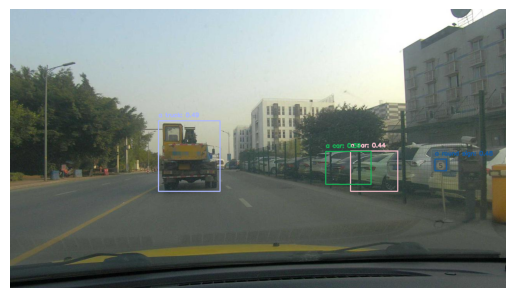

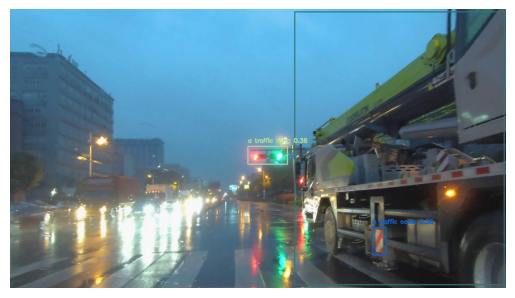

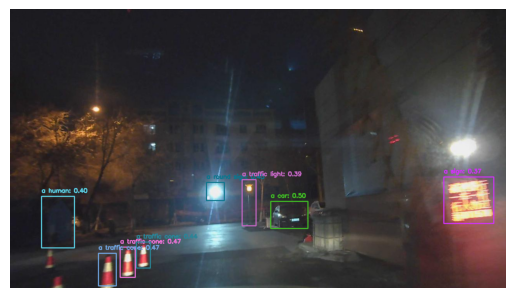

In [14]:
### load the pkl file and show bonding blocks

with open(pickle_file_path, 'rb') as f:
    loaded_annotated_images = pickle.load(f)

# Show the first image to verify it was loaded correctly
for img_array in loaded_annotated_images:
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()

In [ ]:
### Get RAG tensor

input_file = '/content/Out.json'

# Open and load the JSON file into a Python dictionary
with open(input_file, 'r') as json_file:
    rag_data = json.load(json_file)

bert_list = []

# Iterate through rag_data and extract the 'bert' values
for item_id, item_data in rag_data.items():
    bert_list.append(item_data['bert'][0])

bert_list = torch.tensor(bert_list).to(0)
# Now bert_list contains all the 'bert' values
print(bert_list)

tensor([[-0.3806, -0.8939, -0.7248,  ..., -1.0201, -0.4252,  0.0458],
        [-0.3681, -0.7467, -0.9528,  ..., -0.7638, -0.3416, -0.0939],
        [-0.3448, -0.9067, -0.5574,  ..., -0.9854, -0.5028,  0.3178],
        ...,
        [-0.6173, -0.8312, -1.0503,  ..., -1.0425,  0.0439,  0.3086],
        [-0.3240, -0.5494, -0.9825,  ..., -0.8232, -0.2133,  0.3661],
        [-0.3943, -0.6946, -0.8680,  ..., -1.1963, -0.5321,  0.2989]],
       device='cuda:0')


In [ ]:
### Inference

image = Image.open("/content/6.jpg") # Your local image
inputs = GD_processor(images=image, text=labels, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = GD_model(**inputs)
results = GD_processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.35,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)
detections = DetectionResult.from_dict(results[0])

inputs = Dep_image_processor(images=image, return_tensors="pt").to(0)
with torch.no_grad():
  outputs = Dep_model(**inputs)

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])
img = transform(image)
img *= 255
target_sizes = [(img.shape[1], img.shape[2])]

# interpolate to original size and visualize the prediction
post_processed_output = Dep_image_processor.post_process_depth_estimation(
    outputs,
    target_sizes,
)
# print(type(post_processed_output))
normalized_depths = []
for i in range(len(post_processed_output)):
    depth = post_processed_output[i]["predicted_depth"]

    normalized_depth = (depth - depth.min()) / (depth.max() - depth.min())  # Normalize to [0, 1]
    normalized_depth = normalized_depth * 255
    normalized_depths.append(normalized_depth)
normalized_depths = torch.stack(normalized_depths, dim=0)

data_one_image = []
for i in range(len(results[0]['labels'])):
    boxes = results[0]['boxes'][i].cpu()
    # print(boxes)
    mean_value = normalized_depths[0].cpu()[int((boxes[1] + boxes[3])//2)][int((boxes[0] + boxes[2])//2)]
    d_range = ""
    orient = ""
    if mean_value > 90:
      d_range = "immediate"
    elif mean_value > 70:
      d_range = "short"
    elif mean_value > 40:
      d_range = "mid"
    else:
      d_range = "long"

    x_mean_value = (boxes[0] + boxes[2])//2
    if x_mean_value > 0.8 * normalized_depths[0].shape[1]:
      orient = "right"
    elif x_mean_value > 0.6 * normalized_depths[0].shape[1]:
      orient = "middle-right"
    elif x_mean_value > 0.4 * normalized_depths[0].shape[1]:
      orient = "middle"
    elif x_mean_value > 0.2 * normalized_depths[0].shape[1]:
      orient = "middle-left"
    else:
      orient = "left"
    data_one_image.append(f"{results[0]['labels'][i]}_{d_range}_{orient}")

json_string = " ".join(data_one_image)
inputs = Bert_tokenizer(json_string, return_tensors="pt", truncation=True, padding=True).to(0)
outputs = Bert_model(**inputs)
origin = plot_detections(np.array(image), detections, "cute_cats.png")
text_features = outputs.last_hidden_state[:, 0, :]  # Shape: [batch_size, hidden_size]
print(json_string)

a round sign_mid_middle-right a car a truck_short_middle-right a motorcycle_long_middle a traffic light_mid_middle-right a barrier_short_middle-left a sign_mid_middle-left a car a truck_short_middle-right


In [ ]:
### Compare (It costs much time at the first run)

from time import perf_counter as timer
from sentence_transformers import util

start_time = timer()
dot_scores = util.cos_sim(a=text_features[0], b=bert_list)[0]
end_time = timer()

print(f"Time take to get scores on {len(bert_list)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=3)
top_results_dot_product

Time take to get scores on 301 embeddings: 0.00513 seconds.


torch.return_types.topk(
values=tensor([0.9804, 0.9757, 0.9747], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([296, 161,  35], device='cuda:0'))

Origin


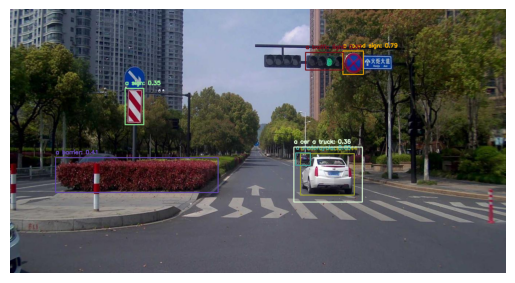

Top 3


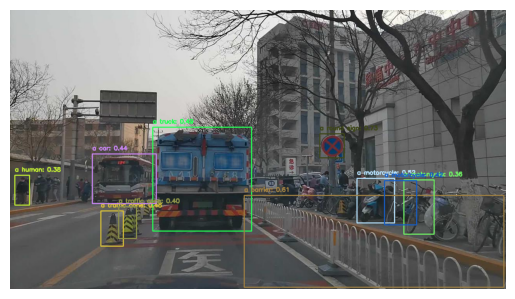

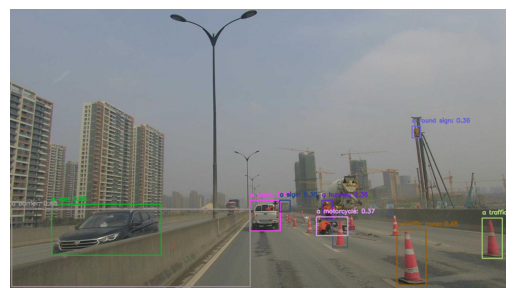

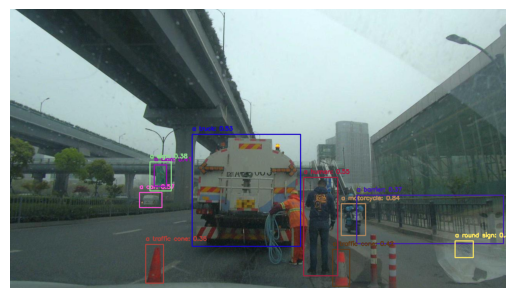

In [ ]:
## Show result

print("Origin")
plt.imshow(origin)
plt.axis('off')
plt.show()

print("Top 3")
for i in top_results_dot_product.indices:
    plt.imshow(annotated_image[i])
    plt.axis('off')
    plt.show()